<a href="https://colab.research.google.com/github/alexandrgsv/stock_prediction_models/blob/main/MMVB_LSTM_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [188]:
# Load the data
data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D', header=0, usecols=['<DATE>', '<CLOSE>'], date_parser=True)
df = data[['<DATE>', '<CLOSE>']].copy()

In [189]:
df['<DATE>'] = pd.to_datetime(df['<DATE>'])
df = df.set_index('<DATE>').sort_index()
scaler = MinMaxScaler()
df['close_scaled'] = scaler.fit_transform(df[['<CLOSE>']])


In [190]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]


In [191]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    X, y = np.array(X), np.array(y)
    return X, y

n_steps = 30

X_train, y_train = create_sequences(train['close_scaled'], n_steps)
X_test, y_test = create_sequences(test['close_scaled'], n_steps)


In [192]:
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])


In [193]:
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)


Epoch 1/100
125/125 [==============================] - 28s 31ms/step - loss: 0.0110
Epoch 2/100
125/125 [==============================] - 5s 38ms/step - loss: 0.0013
Epoch 3/100
125/125 [==============================] - 4s 30ms/step - loss: 0.0013
Epoch 4/100
125/125 [==============================] - 4s 31ms/step - loss: 0.0012
Epoch 5/100
125/125 [==============================] - 5s 39ms/step - loss: 0.0012
Epoch 6/100
125/125 [==============================] - 4s 31ms/step - loss: 0.0012
Epoch 7/100
125/125 [==============================] - 4s 30ms/step - loss: 0.0013
Epoch 8/100
125/125 [==============================] - 5s 39ms/step - loss: 0.0013
Epoch 9/100
125/125 [==============================] - 4s 31ms/step - loss: 0.0012
Epoch 10/100
125/125 [==============================] - 4s 30ms/step - loss: 0.0012
Epoch 11/100
125/125 [==============================] - 5s 39ms/step - loss: 0.0012
Epoch 12/100
125/125 [==============================] - 4s 30ms/step - loss: 0.0011


In [194]:
test_loss = model.evaluate(X_test, y_test)
print('Test loss:', test_loss)


31/31 [==============================] - 1s 10ms/step - loss: 0.0040
Test loss: 0.004033771809190512


In [203]:
y_pred = model.predict(np.reshape(X_test, (-1,30,1)))
y_pred = scaler.inverse_transform(y_pred)


31/31 [==============================] - 0s 10ms/step


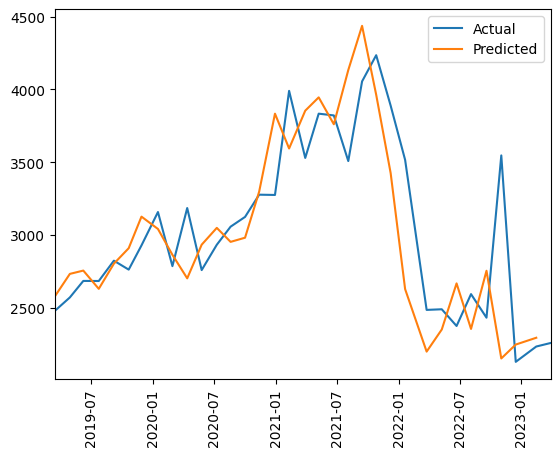

In [222]:
plt.plot(test.index[::n_steps], test['<CLOSE>'][::n_steps], label='Actual')
plt.plot(test.index[:len(y_pred):n_steps], y_pred[:, 0][::n_steps], label='Predicted')


plt.xlim(left=test.index[0], right=test.index[-17])
# rotate the x-axis tick labels
plt.xticks(rotation=90)

plt.legend()
plt.show()

#y_true = scaler.inverse_transform(test['close_scaled'].values.reshape(-1, 1))

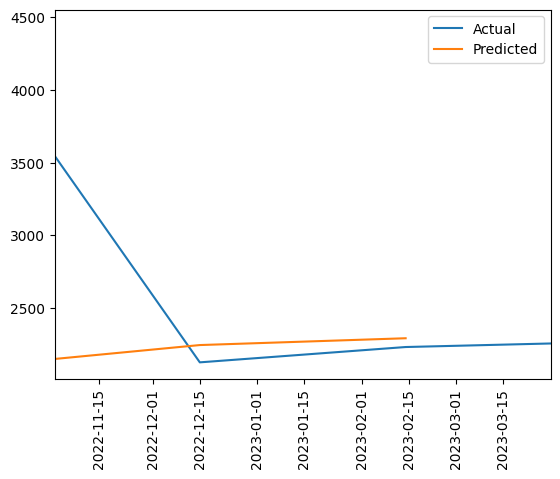

In [223]:
plt.plot(test.index[::n_steps], test['<CLOSE>'][::n_steps], label='Actual')
plt.plot(test.index[:len(y_pred):n_steps], y_pred[:, 0][::n_steps], label='Predicted')


plt.xlim(left=test.index[900], right=test.index[-17])
# rotate the x-axis tick labels
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [197]:
n_forecast = 16
inputs = test['close_scaled'][-n_steps:].values.reshape(1, -1, 1)
forecast = []
for i in range(n_forecast):
    y_pred = model.predict(inputs)
    forecast.append(y_pred[0, 0])
    inputs = np.concatenate([inputs[:, 1:, :], y_pred.reshape(1, 1, 1)], axis=1)
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()



1/1 [==============================] - 0s 30ms/step


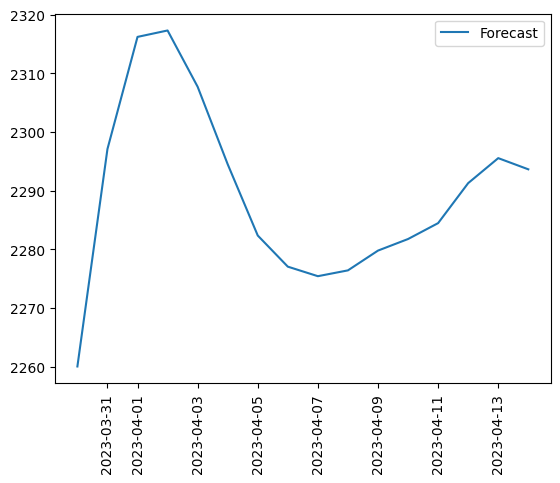

In [224]:
last_date = test.index[-17]
forecast_dates = pd.date_range(start=last_date, periods=n_forecast+1, freq='D')[1:]
plt.plot(forecast_dates, forecast, label='Forecast')
# rotate the x-axis tick labels
plt.xticks(rotation=90)
plt.legend()
plt.show()
